In [94]:
import numpy as np
import os
import time
import scipy
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.ticker as mtick
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import MinMaxScaler



from distribution import TestDistribution


In [95]:
# compare the performance of four methods


report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/base" 

for method in report_method:
    if method == "ULDPFS_IA":
        log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
        log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params1,params2,params3,params4,params5,time".split(',')
        # merge params1-params5 into one column
        log["params"] = log["params1"].astype(str) + log["params2"].astype(str) + log["params3"].astype(str) + log["params4"].astype(str) + log["params5"].astype(str)
        # remove params1-params5
        log = log.drop(columns=["params1","params2","params3","params4","params5"])
        all_log = pd.concat([all_log, log], ignore_index=True)
        continue
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
    
    
    
values_to_filter = {
    
    "dist_idx" : [1],
    "n": [400],
    "d": [ 256],
    "m": [100],
    "epsilon":[4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]


best_result_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
df_mean = best_result_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()

df_mean

,dist_idx,method,n,d,m,epsilon,params,iterate,accuracy,precision,recall,l2err,l1err,mse,time
0,1,LDPIHT,400,256,100,4,10:10:0.01,14.5,0.789323,0.026667,0.016667,1.045227,3.379423,2.104609,3.073318
1,1,NLDPSLR,400,256,100,4,39.163949290893065:4:8:0.05,14.5,0.729427,0.016938,0.279167,11.267595,138.061175,3447.394448,444.515302
2,1,ULDPFS,400,256,100,4,postlasso:{'num_bins': 16},14.5,0.966406,0.495732,0.512500,0.237534,0.610121,1.087044,0.225831
3,1,ULDPFS_IA,400,256,100,4,postlasso:{'num_bins': 8 'B': 3 'batch_size': ...,14.5,0.972526,0.575387,0.591667,0.378318,1.063748,1.159030,0.194311


## m - l2

/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/pyth

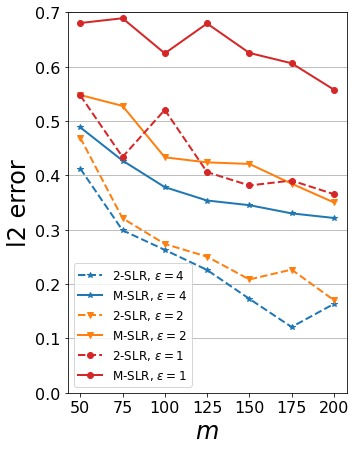

In [96]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/m" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
# filter the potential values
values_to_filter = {
    "dist_idx" : [1],
    "n": [400],
    "d": [ 256],
    "m": [50, 75, 100, 125, 150, 175, 200],
    "epsilon":[1,2,4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.8)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.2)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()



fig, ax = plt.subplots(figsize=(5,7))

x = best_mean_log['m'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]

y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4')


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e')



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 1$', marker = "o", color = '#d62728', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 1$', marker = "o", color = '#d62728')


_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$m$", fontsize=24)
_ = plt.ylim(0, 0.7)
_ = plt.legend(fontsize = 12)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x.values)


plt.savefig("./plots/m-l2-independent.pdf",bbox_inches="tight")



## n - l2

/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/pyth

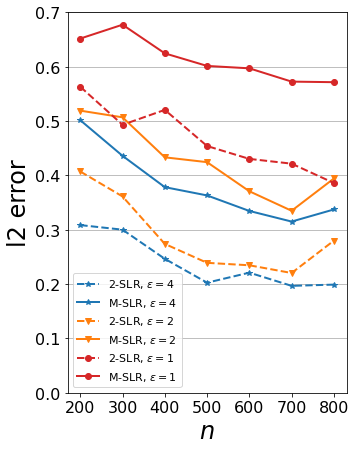

In [97]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/n" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [1],
    "n": [200, 300, 400, 500, 600, 700, 800],
    "d": [ 256],
    "m": [100],
    "epsilon":[1,2,4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.8)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.2)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()


fig, ax = plt.subplots(figsize=(5,7))

x = best_mean_log['n'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]

y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4')


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e')



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 1$', marker = "o", color = '#d62728', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 1$', marker = "o", color = '#d62728')


_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$n$", fontsize=24)
_ = plt.ylim(0, 0.7)
_ = plt.legend(fontsize = 11)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x.values)


plt.savefig("./plots/n-l2-independent.pdf", bbox_inches="tight")



# l2 - d

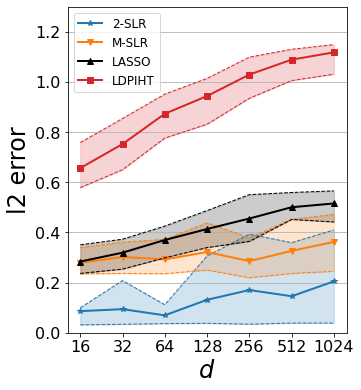

In [98]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/d" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [1],
    "n": [400],
    "d": [ 16, 32, 64, 128, 256, 512, 1024],
    "m": [200],
    "epsilon":[4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.9)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.1)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()

fig, ax = plt.subplots(figsize=(5,6))

x = np.arange(len(values_to_filter["d"]))
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#1f77b4')
_ = plt.plot(x, y, linewidth = 2,label = '2-SLR', marker = "*", color = '#1f77b4')
_ = plt.plot(x, yup, linewidth = 1, color = '#1f77b4', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#1f77b4', linestyle = "dashed")



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS_IA") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS_IA") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#ff7f0e')
_ = plt.plot(x, y, linewidth = 2,label = 'M-SLR', marker = "v", color = '#ff7f0e')
_ = plt.plot(x, yup, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")


y = best_mean_log['l2err'][(best_mean_log["method"] == "LOCALLASSO") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LOCALLASSO") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LOCALLASSO") ]
_ = plt.plot(x, y, linewidth = 2,label = 'LASSO', color = "black", marker = "^")
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = 'black')
_ = plt.plot(x, yup, linewidth = 1, color = 'black', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = 'black', linestyle = "dashed")



y = best_mean_log['l2err'][(best_mean_log["method"] == "LDPIHT") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LDPIHT") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LDPIHT") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#d62728')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPIHT', marker = "s", color = '#d62728')
_ = plt.plot(x, yup, linewidth = 1, color = '#d62728', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#d62728', linestyle = "dashed")



# too much variation, use median
# best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_mid).reset_index()
# best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()

# y = best_mean_log['l2err'][(best_mean_log["method"] == "NLDPSLR") ]
# yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "NLDPSLR") ]
# ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "NLDPSLR") ]
# _ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#2ca02c')
# _ = plt.plot(x, y, linewidth = 2,label = 'NLDPSLR', marker = "o", color = '#2ca02c')
# _ = plt.plot(x, yup, linewidth = 1, color = '#2ca02c', linestyle = "dashed")
# _ = plt.plot(x, ylow, linewidth = 1, color = '#2ca02c', linestyle = "dashed")

_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$d$", fontsize=24)
_ = plt.ylim(0, 1.3)
_ = plt.legend(fontsize = 12, loc = 2)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( values_to_filter["d"])


plt.savefig("./plots/d-l2-m200-independent.pdf",bbox_inches="tight")



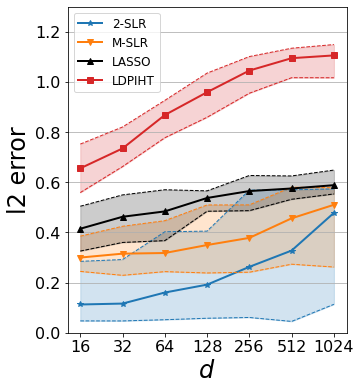

In [99]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/d" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [1],
    "n": [400],
    "d": [ 16, 32, 64, 128, 256, 512, 1024],
    "m": [100],
    "epsilon":[4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.9)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.1)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()

fig, ax = plt.subplots(figsize=(5,6))

x = np.arange(len(values_to_filter["d"]))
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#1f77b4')
_ = plt.plot(x, y, linewidth = 2,label = '2-SLR', marker = "*", color = '#1f77b4')
_ = plt.plot(x, yup, linewidth = 1, color = '#1f77b4', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#1f77b4', linestyle = "dashed")



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS_IA") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS_IA") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#ff7f0e')
_ = plt.plot(x, y, linewidth = 2,label = 'M-SLR', marker = "v", color = '#ff7f0e')
_ = plt.plot(x, yup, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")


y = best_mean_log['l2err'][(best_mean_log["method"] == "LOCALLASSO") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LOCALLASSO") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LOCALLASSO") ]
_ = plt.plot(x, y, linewidth = 2,label = 'LASSO', color = "black", marker = "^")
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = 'black')
_ = plt.plot(x, yup, linewidth = 1, color = 'black', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = 'black', linestyle = "dashed")


y = best_mean_log['l2err'][(best_mean_log["method"] == "LDPIHT") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LDPIHT") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LDPIHT") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#d62728')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPIHT', marker = "s", color = '#d62728')
_ = plt.plot(x, yup, linewidth = 1, color = '#d62728', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#d62728', linestyle = "dashed")




# too much variation, use median
# best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_mid).reset_index()
# best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()

# y = best_mean_log['l2err'][(best_mean_log["method"] == "NLDPSLR") ]
# yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "NLDPSLR") ]
# ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "NLDPSLR") ]
# _ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#2ca02c')
# _ = plt.plot(x, y, linewidth = 2,label = 'NLDPSLR', marker = "o", color = '#2ca02c')
# _ = plt.plot(x, yup, linewidth = 1, color = '#2ca02c', linestyle = "dashed")
# _ = plt.plot(x, ylow, linewidth = 1, color = '#2ca02c', linestyle = "dashed")

_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$d$", fontsize=24)
_ = plt.ylim(0, 1.3)
_ = plt.legend(fontsize = 12, loc = 2)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( values_to_filter["d"])


plt.savefig("./plots/d-l2-m100-independent.pdf",bbox_inches="tight")



## f1 - d

<ipython-input-100-3d72efdbdac6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log["f1"] = 2 * filtered_log["precision"] * filtered_log["recall"] / (filtered_log["precision"] + filtered_log["recall"])


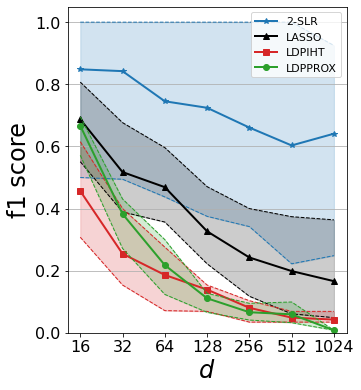

In [100]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "LOCALLASSO", "NLDPSLR"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/d" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [1],
    "n": [400],
    "d": [ 16, 32, 64, 128, 256, 512, 1024],
    "m": [100],
    "epsilon":[4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]



# add a column of f1 score
filtered_log["f1"] = 2 * filtered_log["precision"] * filtered_log["recall"] / (filtered_log["precision"] + filtered_log["recall"])
# remove na
filtered_log = filtered_log.dropna()

quantile_up = lambda vec: np.quantile(vec, 0.9)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.1)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()

best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()

fig, ax = plt.subplots(figsize=(5,6))

x = np.arange(len(values_to_filter["d"]))
y = best_mean_log['f1'][(best_mean_log["method"] == "ULDPFS") ]
yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "ULDPFS") ]
ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "ULDPFS") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#1f77b4')
_ = plt.plot(x, y, linewidth = 2,label = '2-SLR', marker = "*", color = '#1f77b4')
_ = plt.plot(x, yup, linewidth = 1, color = '#1f77b4', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#1f77b4', linestyle = "dashed")



# y = best_mean_log['f1'][(best_mean_log["method"] == "ULDPFS_IA") ]
# yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "ULDPFS_IA") ]
# ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "ULDPFS_IA") ]
# _ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#ff7f0e')
# _ = plt.plot(x, y, linewidth = 2,label = 'M-SLR', marker = "v", color = '#ff7f0e')
# _ = plt.plot(x, yup, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")
# _ = plt.plot(x, ylow, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")


y = best_mean_log['f1'][(best_mean_log["method"] == "LOCALLASSO") ]
yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "LOCALLASSO") ]
ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "LOCALLASSO") ]
_ = plt.plot(x, y, linewidth = 2,label = 'LASSO', color = "black", marker = "^")
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = 'black')
_ = plt.plot(x, yup, linewidth = 1, color = 'black', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = 'black', linestyle = "dashed")

y = best_mean_log['f1'][(best_mean_log["method"] == "LDPIHT") ]
yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "LDPIHT") ]
ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "LDPIHT") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#d62728')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPIHT', marker = "s", color = '#d62728')
_ = plt.plot(x, yup, linewidth = 1, color = '#d62728', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#d62728', linestyle = "dashed")





# too much variation, use median
best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_mid).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()

y = best_mean_log['f1'][(best_mean_log["method"] == "NLDPSLR") ]
yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "NLDPSLR") ]
ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "NLDPSLR") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#2ca02c')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPPROX', marker = "o", color = '#2ca02c')
_ = plt.plot(x, yup, linewidth = 1, color = '#2ca02c', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#2ca02c', linestyle = "dashed")

_ = plt.ylabel("f1 score", fontsize=24)
_ = plt.xlabel(r"$d$", fontsize=24)
_ = plt.ylim(0, 1.05)
_ = plt.legend(fontsize = 11, loc = 1)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( values_to_filter["d"])


plt.savefig("./plots/d-f1-independent.pdf",bbox_inches="tight")



# epsilon - l2

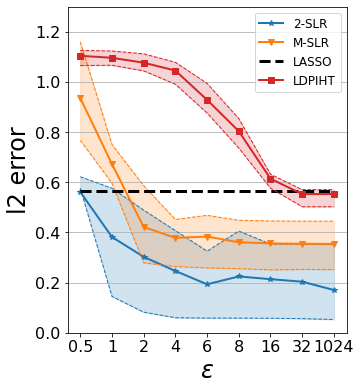

In [101]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/epsilon" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [1],
    "n": [400],
    "d": [ 256],
    "m": [100],
    "epsilon":[0.5, 1, 2, 4, 6, 8, 16, 32, 1024]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.8)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.2)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()

fig, ax = plt.subplots(figsize=(5,6))

x = np.arange(len(values_to_filter["epsilon"]))
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#1f77b4')
_ = plt.plot(x, y, linewidth = 2,label = '2-SLR', marker = "*", color = '#1f77b4')
_ = plt.plot(x, yup, linewidth = 1, color = '#1f77b4', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#1f77b4', linestyle = "dashed")


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS_IA") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS_IA") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#ff7f0e')
_ = plt.plot(x, y, linewidth = 2,label = 'M-SLR', marker = "v", color = '#ff7f0e')
_ = plt.plot(x, yup, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")

# forgot params of lasso, deal separately
y = best_mean_log['l2err'][(best_mean_log["method"] == "LOCALLASSO") ]
_ = plt.plot(x, y, linewidth = 3,label = 'LASSO',  color = "black", linestyle = "dashed")

y = best_mean_log['l2err'][(best_mean_log["method"] == "LDPIHT") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LDPIHT") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LDPIHT") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#d62728')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPIHT', marker = "s", color = '#d62728')
_ = plt.plot(x, yup, linewidth = 1, color = '#d62728', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#d62728', linestyle = "dashed")



# # too much variation, use median
# best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_mid).reset_index()
# best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()


# y = best_mean_log['l2err'][(best_mean_log["method"] == "NLDPSLR") ]
# yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "NLDPSLR") ]
# ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "NLDPSLR") ]
# _ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#2ca02c')
# _ = plt.plot(x, y, linewidth = 2,label = 'NLDPSLR', marker = "o", color = '#2ca02c')
# _ = plt.plot(x, yup, linewidth = 1, color = '#2ca02c', linestyle = "dashed")
# _ = plt.plot(x, ylow, linewidth = 1, color = '#2ca02c', linestyle = "dashed")

_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$\varepsilon$", fontsize=24)
_ = plt.ylim(0, 1.3)
_ = plt.legend(fontsize = 12, loc = 1)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')

x_ticks = [epsilon for epsilon in values_to_filter["epsilon"]]
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( x_ticks)


plt.savefig("./plots/epsilon-l2-independent.pdf",bbox_inches="tight")



## nm - l2 

<ipython-input-102-fce43b1792e0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log["l2err"] = filtered_log["l2err"].astype(float)
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python

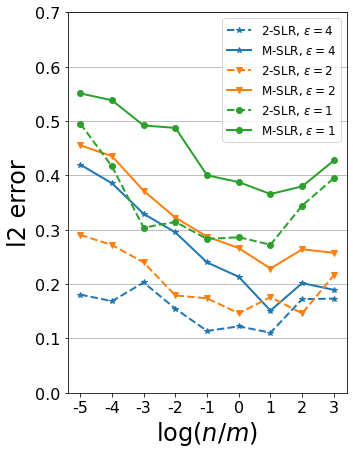

In [102]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/nm" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [1],
    "n": [106, 150, 212, 300, 425, 600, 851, 1200, 1714],
    "d": [ 256],
    # "m": [100],
    "epsilon":[1, 2, 4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]
filtered_log["l2err"] = filtered_log["l2err"].astype(float)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()



fig, ax = plt.subplots(figsize=(5,7))

x = np.log2([0.09375, 0.1875, 0.375, 0.75, 1.5, 3, 6, 12, 24])


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4')


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e')



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 1$', marker = "o", color = '#2ca02c', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 1$', marker = "o", color = '#2ca02c')


_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$\log(n / m)$", fontsize=24)
_ = plt.ylim(0, 0.7)
_ = plt.legend(fontsize = 12, loc = 1)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')

x_ticks = [np.round(ratio - np.log2(3)).astype(int) for ratio in x]
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( x_ticks)


plt.savefig("./plots/nm-l2-independent.pdf",bbox_inches="tight")



## m-l2-correlated 

/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/pyth

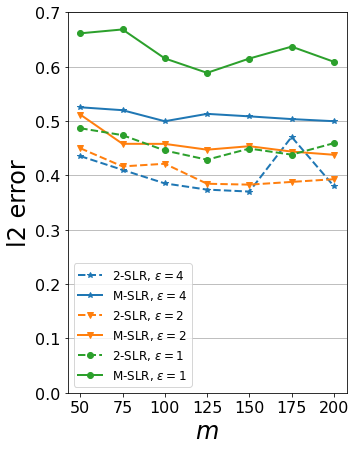

In [110]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/m" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
# filter the potential values
values_to_filter = {
    "dist_idx" : [3],
    "n": [400],
    "d": [ 256],
    "m": [50, 75, 100, 125, 150, 175, 200],
    "epsilon":[1,2,4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.8)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.2)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()



fig, ax = plt.subplots(figsize=(5,7))

x = best_mean_log['m'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]

y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4')


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e')



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 1$', marker = "o", color = '#2ca02c', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 1$', marker = "o", color = '#2ca02c')


_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$m$", fontsize=24)
_ = plt.ylim(0, 0.7)
_ = plt.legend(fontsize = 12)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x.values)


plt.savefig("./plots/m-l2-correlated.pdf",bbox_inches="tight")



## n-l2-correlated 

/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/pyth

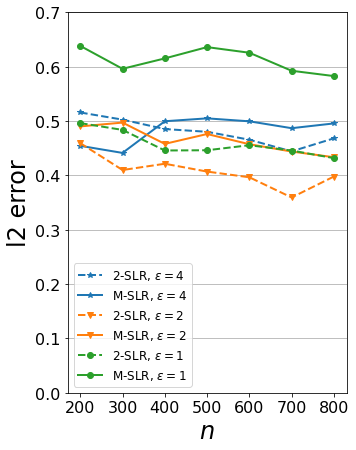

In [111]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/n" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [3],
    "n": [200, 300, 400, 500, 600, 700, 800],
    "d": [ 256],
    "m": [100],
    "epsilon":[1,2,4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.8)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.2)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()


fig, ax = plt.subplots(figsize=(5,7))

x = best_mean_log['n'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]

y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4')


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e')



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 1$', marker = "o", color = '#2ca02c', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 1$', marker = "o", color = '#2ca02c')


_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$n$", fontsize=24)
_ = plt.ylim(0, 0.7)
_ = plt.legend(fontsize = 12)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x.values)


plt.savefig("./plots/n-l2-correlated.pdf", bbox_inches="tight")



# l2 - d - correlated

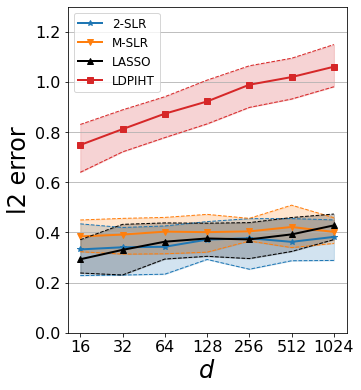

In [105]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/d" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [3],
    "n": [400],
    "d": [ 16, 32, 64, 128, 256, 512, 1024],
    "m": [200],
    "epsilon":[4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.9)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.1)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()

fig, ax = plt.subplots(figsize=(5,6))

x = np.arange(len(values_to_filter["d"]))
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#1f77b4')
_ = plt.plot(x, y, linewidth = 2,label = '2-SLR', marker = "*", color = '#1f77b4')
_ = plt.plot(x, yup, linewidth = 1, color = '#1f77b4', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#1f77b4', linestyle = "dashed")



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS_IA") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS_IA") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#ff7f0e')
_ = plt.plot(x, y, linewidth = 2,label = 'M-SLR', marker = "v", color = '#ff7f0e')
_ = plt.plot(x, yup, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")


y = best_mean_log['l2err'][(best_mean_log["method"] == "LOCALLASSO") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LOCALLASSO") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LOCALLASSO") ]
_ = plt.plot(x, y, linewidth = 2,label = 'LASSO', color = "black", marker = "^")
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = 'black')
_ = plt.plot(x, yup, linewidth = 1, color = 'black', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = 'black', linestyle = "dashed")



y = best_mean_log['l2err'][(best_mean_log["method"] == "LDPIHT") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LDPIHT") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LDPIHT") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#d62728')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPIHT', marker = "s", color = '#d62728')
_ = plt.plot(x, yup, linewidth = 1, color = '#d62728', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#d62728', linestyle = "dashed")



# too much variation, use median
# best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_mid).reset_index()
# best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()

# y = best_mean_log['l2err'][(best_mean_log["method"] == "NLDPSLR") ]
# yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "NLDPSLR") ]
# ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "NLDPSLR") ]
# _ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#2ca02c')
# _ = plt.plot(x, y, linewidth = 2,label = 'NLDPSLR', marker = "o", color = '#2ca02c')
# _ = plt.plot(x, yup, linewidth = 1, color = '#2ca02c', linestyle = "dashed")
# _ = plt.plot(x, ylow, linewidth = 1, color = '#2ca02c', linestyle = "dashed")

_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$d$", fontsize=24)
_ = plt.ylim(0, 1.3)
_ = plt.legend(fontsize = 12, loc = 2)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( values_to_filter["d"])


plt.savefig("./plots/d-l2-m200-correlated.pdf",bbox_inches="tight")



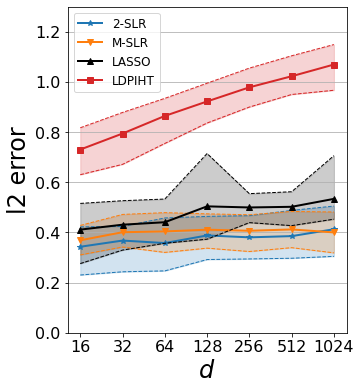

In [106]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/d" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [3],
    "n": [400],
    "d": [ 16, 32, 64, 128, 256, 512, 1024],
    "m": [100],
    "epsilon":[4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.9)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.1)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()

fig, ax = plt.subplots(figsize=(5,6))

x = np.arange(len(values_to_filter["d"]))
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#1f77b4')
_ = plt.plot(x, y, linewidth = 2,label = '2-SLR', marker = "*", color = '#1f77b4')
_ = plt.plot(x, yup, linewidth = 1, color = '#1f77b4', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#1f77b4', linestyle = "dashed")



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS_IA") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS_IA") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#ff7f0e')
_ = plt.plot(x, y, linewidth = 2,label = 'M-SLR', marker = "v", color = '#ff7f0e')
_ = plt.plot(x, yup, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")


y = best_mean_log['l2err'][(best_mean_log["method"] == "LOCALLASSO") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LOCALLASSO") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LOCALLASSO") ]
_ = plt.plot(x, y, linewidth = 2,label = 'LASSO', color = "black", marker = "^")
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = 'black')
_ = plt.plot(x, yup, linewidth = 1, color = 'black', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = 'black', linestyle = "dashed")


y = best_mean_log['l2err'][(best_mean_log["method"] == "LDPIHT") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LDPIHT") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LDPIHT") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#d62728')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPIHT', marker = "s", color = '#d62728')
_ = plt.plot(x, yup, linewidth = 1, color = '#d62728', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#d62728', linestyle = "dashed")




# too much variation, use median
# best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_mid).reset_index()
# best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()

# y = best_mean_log['l2err'][(best_mean_log["method"] == "NLDPSLR") ]
# yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "NLDPSLR") ]
# ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "NLDPSLR") ]
# _ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#2ca02c')
# _ = plt.plot(x, y, linewidth = 2,label = 'NLDPSLR', marker = "o", color = '#2ca02c')
# _ = plt.plot(x, yup, linewidth = 1, color = '#2ca02c', linestyle = "dashed")
# _ = plt.plot(x, ylow, linewidth = 1, color = '#2ca02c', linestyle = "dashed")

_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$d$", fontsize=24)
_ = plt.ylim(0, 1.3)
_ = plt.legend(fontsize = 12, loc = 2)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( values_to_filter["d"])


plt.savefig("./plots/d-l2-m100-correlated.pdf",bbox_inches="tight")



 ## f1 - d - correlated

<ipython-input-107-d0e5c0836154>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log["f1"] = 2 * filtered_log["precision"] * filtered_log["recall"] / (filtered_log["precision"] + filtered_log["recall"])


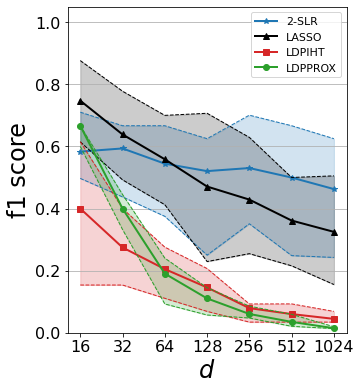

In [107]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "LOCALLASSO", "NLDPSLR"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/d" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [3],
    "n": [400],
    "d": [ 16, 32, 64, 128, 256, 512, 1024],
    "m": [100],
    "epsilon":[4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]



# add a column of f1 score
filtered_log["f1"] = 2 * filtered_log["precision"] * filtered_log["recall"] / (filtered_log["precision"] + filtered_log["recall"])
# remove na
filtered_log = filtered_log.dropna()

quantile_up = lambda vec: np.quantile(vec, 0.9)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.1)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()

best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "epsilon"]).agg("min").reset_index()

fig, ax = plt.subplots(figsize=(5,6))

x = np.arange(len(values_to_filter["d"]))
y = best_mean_log['f1'][(best_mean_log["method"] == "ULDPFS") ]
yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "ULDPFS") ]
ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "ULDPFS") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#1f77b4')
_ = plt.plot(x, y, linewidth = 2,label = '2-SLR', marker = "*", color = '#1f77b4')
_ = plt.plot(x, yup, linewidth = 1, color = '#1f77b4', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#1f77b4', linestyle = "dashed")



# y = best_mean_log['f1'][(best_mean_log["method"] == "ULDPFS_IA") ]
# yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "ULDPFS_IA") ]
# ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "ULDPFS_IA") ]
# _ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#ff7f0e')
# _ = plt.plot(x, y, linewidth = 2,label = 'M-SLR', marker = "v", color = '#ff7f0e')
# _ = plt.plot(x, yup, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")
# _ = plt.plot(x, ylow, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")


y = best_mean_log['f1'][(best_mean_log["method"] == "LOCALLASSO") ]
yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "LOCALLASSO") ]
ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "LOCALLASSO") ]
_ = plt.plot(x, y, linewidth = 2,label = 'LASSO', color = "black", marker = "^")
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = 'black')
_ = plt.plot(x, yup, linewidth = 1, color = 'black', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = 'black', linestyle = "dashed")

y = best_mean_log['f1'][(best_mean_log["method"] == "LDPIHT") ]
yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "LDPIHT") ]
ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "LDPIHT") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#d62728')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPIHT', marker = "s", color = '#d62728')
_ = plt.plot(x, yup, linewidth = 1, color = '#d62728', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#d62728', linestyle = "dashed")





# too much variation, use median
best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_mid).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()

y = best_mean_log['f1'][(best_mean_log["method"] == "NLDPSLR") ]
yup = best_upquantile_log['f1'][(best_upquantile_log["method"] == "NLDPSLR") ]
ylow = best_lowquantile_log['f1'][(best_lowquantile_log["method"] == "NLDPSLR") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#2ca02c')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPPROX', marker = "o", color = '#2ca02c')
_ = plt.plot(x, yup, linewidth = 1, color = '#2ca02c', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#2ca02c', linestyle = "dashed")

_ = plt.ylabel("f1 score", fontsize=24)
_ = plt.xlabel(r"$d$", fontsize=24)
_ = plt.ylim(0, 1.05)
_ = plt.legend(fontsize = 11, loc = 1)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( values_to_filter["d"])


plt.savefig("./plots/d-f1-correlated.pdf",bbox_inches="tight")



# epsilon - l2 -correlated

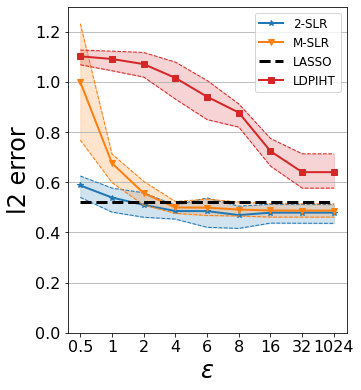

In [108]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/epsilon" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [3],
    "n": [400],
    "d": [ 256],
    "m": [100],
    "epsilon":[0.5, 1, 2, 4, 6, 8, 16, 32, 1024]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]

quantile_up = lambda vec: np.quantile(vec, 0.8)
quantile_mid = lambda vec: np.quantile(vec, 0.5)
quantile_low = lambda vec: np.quantile(vec, 0.2)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_upquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_up).reset_index()
best_lowquantile_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_low).reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()
best_upquantile_log = best_upquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()
best_lowquantile_log = best_lowquantile_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg("min").reset_index()

fig, ax = plt.subplots(figsize=(5,6))

x = np.arange(len(values_to_filter["epsilon"]))
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#1f77b4')
_ = plt.plot(x, y, linewidth = 2,label = '2-SLR', marker = "*", color = '#1f77b4')
_ = plt.plot(x, yup, linewidth = 1, color = '#1f77b4', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#1f77b4', linestyle = "dashed")


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "ULDPFS_IA") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "ULDPFS_IA") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#ff7f0e')
_ = plt.plot(x, y, linewidth = 2,label = 'M-SLR', marker = "v", color = '#ff7f0e')
_ = plt.plot(x, yup, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#ff7f0e', linestyle = "dashed")

# forgot params of lasso, deal separately
y = best_mean_log['l2err'][(best_mean_log["method"] == "LOCALLASSO") ]
_ = plt.plot(x, y, linewidth = 3,label = 'LASSO',  color = "black", linestyle = "dashed")

y = best_mean_log['l2err'][(best_mean_log["method"] == "LDPIHT") ]
yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "LDPIHT") ]
ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "LDPIHT") ]
_ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#d62728')
_ = plt.plot(x, y, linewidth = 2,label = 'LDPIHT', marker = "s", color = '#d62728')
_ = plt.plot(x, yup, linewidth = 1, color = '#d62728', linestyle = "dashed")
_ = plt.plot(x, ylow, linewidth = 1, color = '#d62728', linestyle = "dashed")



# # too much variation, use median
# best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg(quantile_mid).reset_index()
# best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()


# y = best_mean_log['l2err'][(best_mean_log["method"] == "NLDPSLR") ]
# yup = best_upquantile_log['l2err'][(best_upquantile_log["method"] == "NLDPSLR") ]
# ylow = best_lowquantile_log['l2err'][(best_lowquantile_log["method"] == "NLDPSLR") ]
# _ = ax.fill_between(x, ylow, yup, alpha=.2, color = '#2ca02c')
# _ = plt.plot(x, y, linewidth = 2,label = 'NLDPSLR', marker = "o", color = '#2ca02c')
# _ = plt.plot(x, yup, linewidth = 1, color = '#2ca02c', linestyle = "dashed")
# _ = plt.plot(x, ylow, linewidth = 1, color = '#2ca02c', linestyle = "dashed")

_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$\varepsilon$", fontsize=24)
_ = plt.ylim(0, 1.3)
_ = plt.legend(fontsize = 12, loc = 1)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')

x_ticks = [epsilon for epsilon in values_to_filter["epsilon"]]
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( x_ticks)


plt.savefig("./plots/epsilon-l2-correlated.pdf",bbox_inches="tight")



## nm - l2 correlated

<ipython-input-109-c2cf4f06744d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log["l2err"] = filtered_log["l2err"].astype(float)
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/samsung/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python

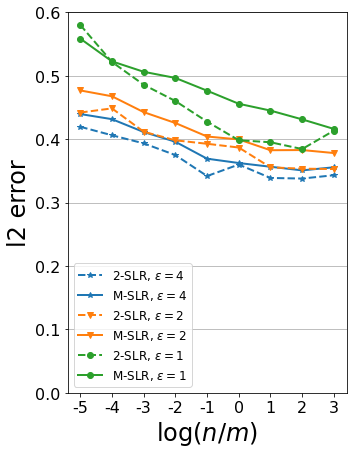

In [109]:

report_method = ["ULDPFS", "ULDPFS_IA", "LDPIHT", "NLDPSLR", "LOCALLASSO"]
all_log = pd.DataFrame([])
log_file_dir = "./logs/nm" 

for method in report_method:
    log = pd.read_csv("{}/{}.csv".format(log_file_dir,method), header=None)
    log.columns = "dist_idx,method,iterate,epsilon,n,d,m,accuracy,precision,recall,l2err,l1err,mse,params,time".split(',')
    # stack log onto all_log
    all_log = pd.concat([all_log, log], ignore_index=True)
    
values_to_filter = {
    "dist_idx" : [3],
    "n": [106, 150, 212, 300, 425, 600, 851, 1200, 1714],
    "d": [ 256],
    # "m": [100],
    "epsilon":[1, 2, 4]
}
mask_list = [all_log[col].isin(values) for col, values in values_to_filter.items()]
combined_mask = mask_list[0]
for mask in mask_list[1:]:
    combined_mask = combined_mask & mask
filtered_log = all_log[combined_mask]
filtered_log["l2err"] = filtered_log["l2err"].astype(float)

best_mean_log = filtered_log.groupby(by=["dist_idx", "method", "epsilon", "n", "d", "m", "params"]).agg('mean').reset_index()
best_mean_log = best_mean_log.groupby(by=["dist_idx", "method", "n", "d", "m", "epsilon"]).agg('min').reset_index()



fig, ax = plt.subplots(figsize=(5,7))

x = np.log2([0.09375, 0.1875, 0.375, 0.75, 1.5, 3, 6, 12, 24])


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 4)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 4$', marker = "*", color = '#1f77b4')


y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 2)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 2$', marker = "v", color = '#ff7f0e')



y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'2-SLR, $\varepsilon = 1$', marker = "o", color = '#2ca02c', linestyle = "dashed")
y = best_mean_log['l2err'][(best_mean_log["method"] == "ULDPFS_IA") * (best_mean_log["epsilon"] == 1)]
_ = plt.plot(x, y, linewidth = 2,label = r'M-SLR, $\varepsilon = 1$', marker = "o", color = '#2ca02c')


_ = plt.ylabel("l2 error", fontsize=24)
_ = plt.xlabel(r"$\log(n / m)$", fontsize=24)
_ = plt.ylim(0, 0.6)
_ = plt.legend(fontsize = 12)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.grid(axis = 'y')

x_ticks = [np.round(ratio - np.log2(3)).astype(int) for ratio in x]
_ = ax.set_xticks( x)
_ = ax.set_xticklabels( x_ticks)


plt.savefig("./plots/nm-l2-correlated.pdf",bbox_inches="tight")

